# Detect pneumonia in X-ray that can be caused by Covid-19

In this notebook we will learn how to detect pneumonia in x-ray images using Pytorch and deep learning networks, We will use a pre-trained model from PyTorch models zoo and we will retrain the last parts of the network on our problem.
We will use the python and GPU environment in Watson studio for faster training, Without having to go anywhere else we will be able to download, explore, built, and train our model.


<img src="https://raw.githubusercontent.com/mostafa3m/x-ray/35b011ac93ce75f6bdbff7fd7cf2dfce10995672/img.jpeg" alt="x-ray" width="80%%" height="80%"/>


In this notebook, we will use PyTorch to build and train a deep learning model to classify images to two classes normal and pneumonia which can indicate a big chance of being caused by the COVID-19 virus. We will use a pre-trained densenet network and we will define our classifier and connect it to network, then train this classifier along with the last dense block of the network on our x-ray dataset.

In this notebook we will:

1- Obtain dataset from Kaggle.  
2- explore data and define transformers to preprocess images before training.  
3- define our classifier to have an output layer of 2 outputs.  
4- train the last block of the network along with the classifier we defined.  
5- test the model we trained.  

This notebook uses python 3.6 + GPU environment which allow us to do the whole process and train complex model in the same place which is a notebook in Watson studio.
Learn more about available environments <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html"> Watson Studio environments.</a>




# Learning Goals

In this notebook, you will learn how to:

* Download and prepare data in Watson studio.  
* Download and retrain pre-trained PyTorch models on your problem.  
* Train and test your model.

# Contents  
1- [Setting up the environment and fetching the dataset](#1.-Fetching-Data).  
2- [Explore dataset folders and show random sample](#2.-Explore-Data).  
3- [preprocess images by transforms and load them to dataloaders](#3.-Process-and-load-images).  
4- [Choose a pre-trained model and retrain](#4.-Customize-our-network).  
5- [Configure training parameters and start the training](#5.-Configure-training-parameters-and-start-the-training).  
6- [Test your trained model on random image](#6.-Test-The-Model).  
7- [Summary and Resources](#7.-Summary-and-Resources).

# 1. Fetching data 

In this section, we will get the required missing packages, download, and unzip the dataset.

## 1.1. Install Kaggle CLI and torch vision package

First, we will need to install Kaggle CLI and torch vision package, For that, we use the exclamation mark to run command in the kernel.

In [1]:
#install torchvision and kaggle

!pip install torchvision
!pip install kaggle

## 1.2. Download and unzip the dataset 

We will use a dataset of 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal) offered by Paul Mooney on Kaggle. For more about the dataset <a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia"> Chest X-Ray Images.</a>

* In this cell you should import your Kaggle account credentials to be able to download the data through Kaggle CLI. To get your credentials <a href="https://www.kaggle.com/docs/api">Kaggle API key.</a>
* Please note the line should be run as it is as one line to make sure all commands are started in the same kernel.

In [2]:
# download dataset and extract it

! export KAGGLE_USERNAME=mostafa3m && export KAGGLE_KEY=53fae4218c22bbfa740beb95301e6e16 && kaggle datasets download --unzip paultimothymooney/chest-xray-pneumonia
! ls

100%|██████████████████████████████████████▉| 2.29G/2.29G [00:14<00:00, 160MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:14<00:00, 173MB/s]
chest_xray


# 2. Explore Data

Here we will explore sub-folders and files of our data and show some samples of it.

In [3]:
! pwd && cd chest_xray/chest_xray && ls && cd train && ls

/home/wsuser/work
test  train  val
NORMAL	PNEUMONIA


As we see the dataset is separated into Train, Test, and validate folders, Each has a folder for normal x-rays and other for pneumonia.
In this notebook, we will only use  train and test folders.  
Now let us load our dataset to data loaders using datasets in torch vision and show some of those images.
* Let us start by importing needed libs

In [4]:
#import  needed libraries and check the used gpu

import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid



* Let us choose some random images and show them  
We will get all images of the two classes from the training data then choose five random indices and plot them in (2 x 5) image grid.

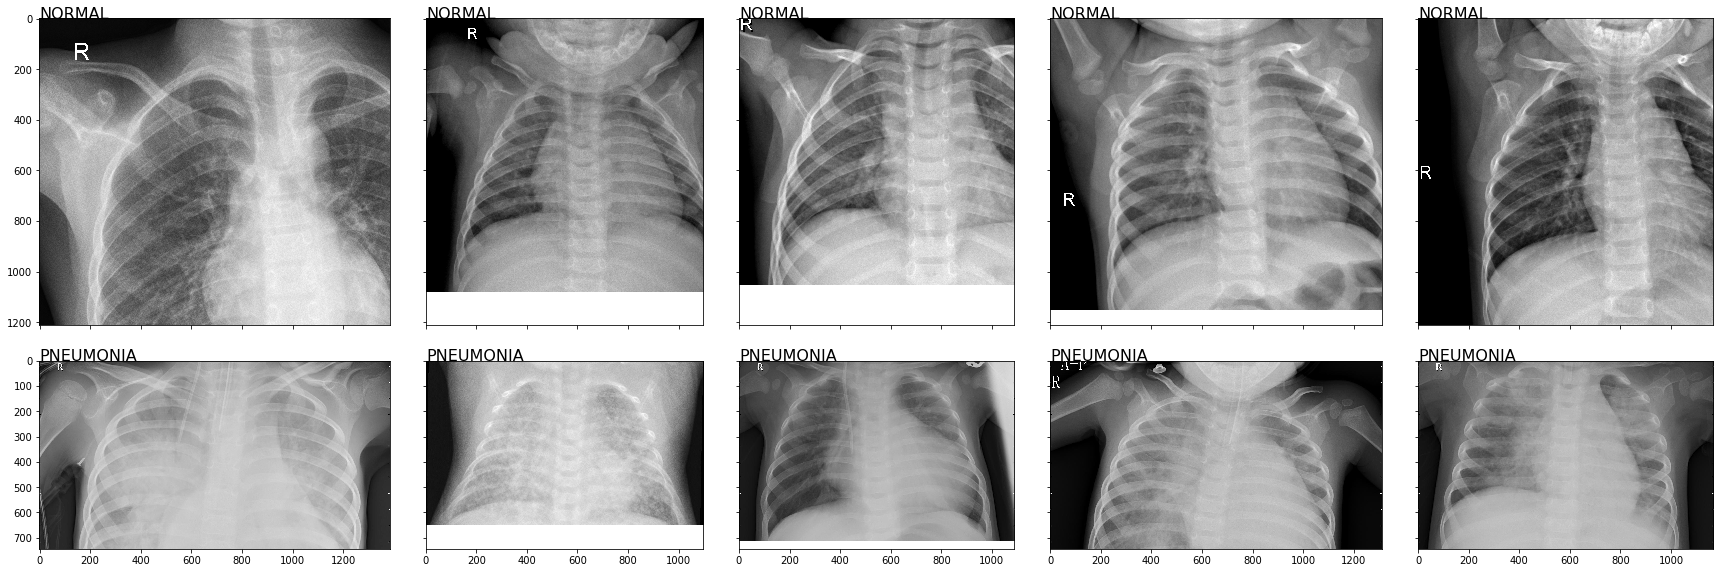

In [5]:
%matplotlib inline

data_dir = 'chest_xray/chest_xray'
normal=np.array(glob.glob(data_dir + '/train/NORMAL/*'))
pn=np.array(glob.glob(data_dir + '/train/PNEUMONIA/*'))
rand_normal_ind = np.random.randint(1,len(normal),5) 
rand_pn_ind = np.random.randint(1,len(pn),5) 

fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),  
                 axes_pad=0.5,  # pad between axes in inch.
                 )
l=0
for img in normal[rand_normal_ind]:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(1,1,"NORMAL",fontsize=16)
        l+=1
for img in pn[rand_pn_ind]:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(1,1,"PNEUMONIA",fontsize=16)
        l+=1

# 3. Process and load images

## 3.1. define transformers  
we now pre-process our images and add some augmentation by rotating images by 30 degrees and flip some of them horizontally.  
All Pytorch pre-trained models expect input images normalized in the same way so we will normalize our images too, learn more <a href="https://pytorch.org/docs/stable/torchvision/models.html">Pytorch docs.</a>

In [6]:
#creating the dataloaders 

data_dir = 'chest_xray/chest_xray'

# Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.Resize((255,255)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((255,255)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

## 3.2. load images to data loaders

Now it is time to create data loaders to feed our model with data during the training phase.  
We also print the used processor to make sure we are using the GPU for faster training, In our case, it is Tesla k80.

In [7]:
# load data to loaders

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)
torch.cuda.get_device_name(0)


'Tesla K80'

# 4. Customize our network

## 4.1. Choose a Pretrained model
choose a pre-trained model you think would have good accuracy for the problem and freeze all layers to make sure not all the network is trained during the training process.   
A list of Pytorch model zoo can be found <a href="https://pytorch.org/docs/stable/torchvision/models.html">here.</a>  
We will also print the model classifier to check the number of input neurons to consider when creating our classifier.

In [8]:
# choose a pretrained model to start with check optioms here: https://pytorch.org/docs/stable/torchvision/models.html
model = models.densenet121(pretrained=True)

# Freeze parameters of the tarined network 

for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it

print (model.classifier)




Linear(in_features=1024, out_features=1000, bias=True)


## 4.2. Choose which layers to train
In the next cell, we will unfreeze the last dense block of our network and we will define our custom classifier to have 2 outputs then we will attach it to the model.  
We will also choose the optimizer we want and define the learning rate for it.

In [9]:
# define new classifier and append it to network but remember to have a 2-neuron output layer for our two classes.

# unlock denseblock4.

for param in model.features.denseblock4.parameters():
    param.requires_grad = True  
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.7),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

# choose your loss function

criterion = nn.NLLLoss()

# define optimizer to train only the classifier

optimizer = optim.Adam([{'params':model.features.denseblock4.parameters()},{'params':model.classifier.parameters()}], lr=0.00005)

#print the network now
print(model.features.denseblock4)
print(model.classifier)
#print the whole model
# print(model)


_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(544, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(576, eps=1e-05, moment

# 5. Configure training parameters and start the training  
## 5.1. choose the number of epochs and printing intervals and move the model to the GPU.

In [10]:
#Define number of epochs through data and run the training loop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 5
steps = 0
running_loss = 0
print_every = 5
trainlossarr=[]
testlossarr=[]


## 5.2. Start the training loop
Set back and watch your model learn.

In [11]:
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
#             plt.plot(trainlossarr, 'b')
#             plt.plot(testlossarr, 'r')
#             plt.show()
            running_loss = 0
            model.train()
        


Epoch 1/5.. Train loss: 0.658.. Test loss: 0.618.. Test accuracy: 0.697
Epoch 1/5.. Train loss: 0.558.. Test loss: 0.579.. Test accuracy: 0.695
Epoch 1/5.. Train loss: 0.482.. Test loss: 0.551.. Test accuracy: 0.695
Epoch 1/5.. Train loss: 0.469.. Test loss: 0.520.. Test accuracy: 0.695
Epoch 2/5.. Train loss: 0.427.. Test loss: 0.482.. Test accuracy: 0.695
Epoch 2/5.. Train loss: 0.377.. Test loss: 0.442.. Test accuracy: 0.737
Epoch 2/5.. Train loss: 0.333.. Test loss: 0.405.. Test accuracy: 0.789
Epoch 2/5.. Train loss: 0.293.. Test loss: 0.371.. Test accuracy: 0.821
Epoch 3/5.. Train loss: 0.267.. Test loss: 0.346.. Test accuracy: 0.839
Epoch 3/5.. Train loss: 0.218.. Test loss: 0.334.. Test accuracy: 0.842
Epoch 3/5.. Train loss: 0.209.. Test loss: 0.336.. Test accuracy: 0.845
Epoch 3/5.. Train loss: 0.188.. Test loss: 0.334.. Test accuracy: 0.850
Epoch 4/5.. Train loss: 0.173.. Test loss: 0.311.. Test accuracy: 0.863
Epoch 4/5.. Train loss: 0.154.. Test loss: 0.304.. Test accuracy

# 6. Test The Model

In [ ]:
### try your model on some images
%matplotlib inline
model.eval()
testloader = torch.utils.data.DataLoader(test_data, batch_size=624)
classes={0:"Normal",1:"PNEUMONIA"}
images , labels=next( iter(testloader) )

index = np.random.randint(0, 623)
test_img=images[index]
plt.imshow(test_img.numpy()[0], cmap='gray')

test_img=test_img.unsqueeze(0).cuda()

res = torch.exp(model(test_img))
print(f"image number {index}")
print("---------------------")

print("label:",classes[labels[index].item()])
print("prediction:", classes[res.argmax().item()])



# 7. Summary and Resources

You made it, Thanks for completing the notebook.  
* In this notebook we learned how to do the whole process of model building and training on notebook leveraging the power GPU environment to train deep learning models.
* Don't forget to get back and try different parameters or different models.

## Resources
* <a href="https://dataplatform.cloud.ibm.com/gallery">Other Great notebooks.</a>  
* <a href="https://www.python.org/">Official Python website.</a>  
* <a href="https://pytorch.org/">Official PyTorch website</a>  
* <a href="https://cloud.ibm.com/registration">Get started today on IBM Cloud for free!</a>   
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/gpu-environments.html">Learn more about GPU environments.</a>   

## Author

Mostafa Abdelaleem is a Developer Advocate at IBM who contributes to AI and data science community in order to democratize them.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.